In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2 as cv
import numpy as np
from utils.io_utils import get_images, output_stereo_calib_results, draw_stereo_pair, draw_stereo_pair_detections
from utils.calib_utils import detect_keypoints, filter_orientation_stereo, get_stereo_calib_input

WARNING - 2021-02-23 16:19:38,135 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-02-23 16:19:38,136 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-02-23 16:19:38,137 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
WARNING - 2021-02-23 16:19:38,138 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
T

In [3]:
pattern_size = (8, 6)
edge_length = 0.055

data_path1 = "/home/konstantin/datasets/bandeja-sequence/2021_02_17/2021-02-17-16-07-15_chessboard_plane/_azure_ir_image_raw"
data_path2 = "/home/konstantin/datasets/bandeja-sequence/2021_02_17/2021-02-17-16-07-15_chessboard_plane/smartphone_video_frames"

file_names1 = np.array(sorted(os.listdir(data_path1), key=str.lower)[:-1])
file_names2 = np.array(sorted(os.listdir(data_path2), key=str.lower)[:-2])


timestamps1 = np.array([int(i.split('.')[0]) for i in file_names1])
timestamps2 = np.array([int(i.split('.')[0]) for i in file_names2])

t_diff = np.abs(timestamps1.reshape(-1, 1) - timestamps2.reshape(1, -1))
nn_t_idx = np.argmin(t_diff, axis=-1)
nn_t_mask = nn_t_idx != (len(timestamps2) - 1)

pair_dict = {}

file_names1 = file_names1[nn_t_mask][::3]
file_names2 = file_names2[nn_t_idx[nn_t_mask]][::3]

for fn1, fn2 in zip(file_names1, file_names2):
    pair_dict[fn1] = fn2

In [4]:
images1 = get_images(data_path1, file_name_list=file_names1)
images2 = get_images(data_path2, file_name_list=file_names2)

In [5]:
results1 = detect_keypoints(images1, pattern_size, edge_length)
results2 = detect_keypoints(images2, pattern_size, edge_length)

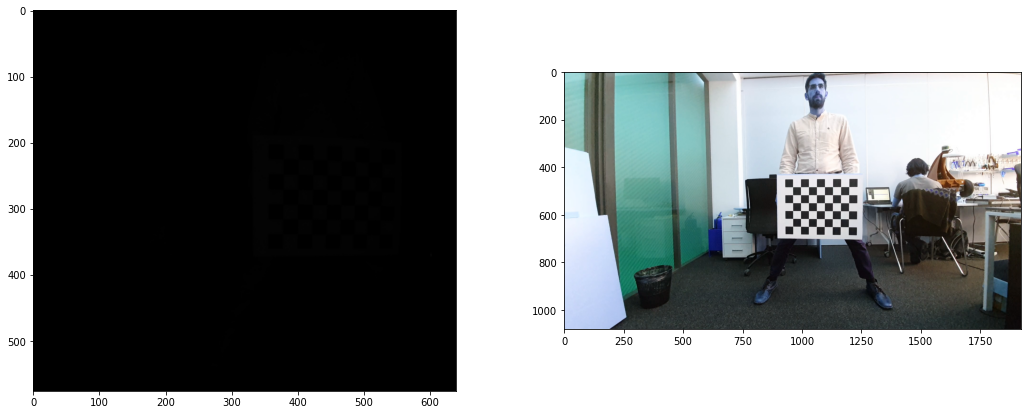

In [6]:
draw_stereo_pair(images1, images2, 0, pair_dict)

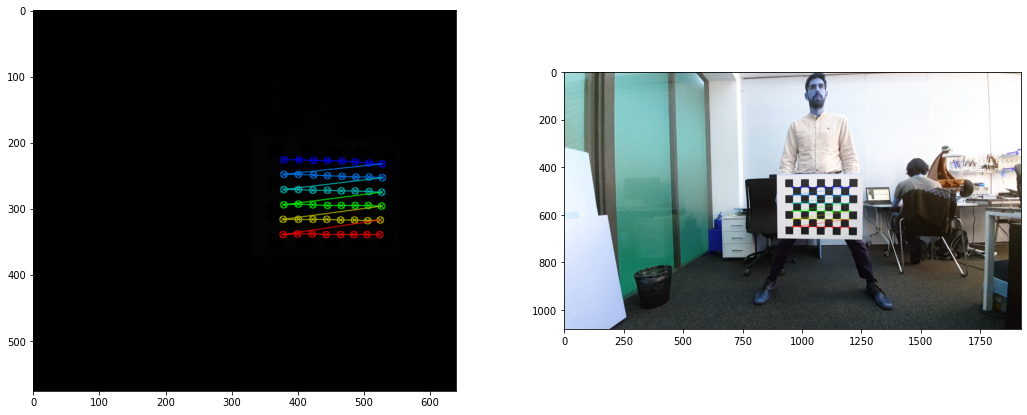

In [7]:
draw_stereo_pair_detections(images1, images2, results1, results2, pattern_size, 0, pair_dict)

In [8]:
calib_intrinsics1 = np.load('calib_output/azure_intrinsics.npy', allow_pickle=True).item()
calib_intrinsics2 = np.load('calib_output/s10_intrinsics.npy', allow_pickle=True).item()

In [9]:
intrinsics1 = calib_intrinsics1['intrinsics']
dist_coeff1 = calib_intrinsics1['dist_coeff']

# intrinsics1 = np.array([[503.9581604003906, 0.0, 325.4591064453125],
#                        [0.0, 504.0079345703125, 340.33404541015625],
#                        [0.0, 0.0, 1.0]])
# dist_coeff1 = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

intrinsics2 = calib_intrinsics2['intrinsics']
dist_coeff2 = calib_intrinsics2['dist_coeff']

In [13]:
# Make sure keypoints have the same orientation
# The orientation of the first pair should be the same in order for this function to give correct results
fresults1, fresults2 = filter_orientation_stereo(results1, results2, pattern_size)

scene_points, loc_kp1, loc_kp2 = get_stereo_calib_input(fresults1, fresults2, pair_dict)

In [11]:
shape = images1[list(images1.keys())[0]].shape[::-1][1:]

reproj_error, _, _, _, _, R12, T12, E12, F12 = cv.stereoCalibrate(scene_points, loc_kp1, loc_kp2, 
                                                                  intrinsics1, dist_coeff1, 
                                                                  intrinsics2, dist_coeff2,
                                                                  shape, flags=cv.CALIB_FIX_INTRINSIC)

print(reproj_error)

5.330797606870633


R:
[[ 0.98733991 -0.01668066  0.15773923]
 [-0.001627    0.99333777  0.1152277 ]
 [-0.15861041 -0.11402554  0.98073488]]
T:
[[-0.33445693]
 [ 0.01996674]
 [ 1.28442658]]
E:
[[-1.07716893e-03 -1.27814615e+00 -1.28419440e-01]
 [ 1.21511727e+00 -5.95617102e-02  5.30618035e-01]
 [-1.91697943e-02 -3.31895642e-01 -4.16882389e-02]]
F:
[[ 7.56108411e-09  8.93920184e-06 -2.56994906e-03]
 [-8.49812633e-06  4.15040164e-07  7.08124659e-04]
 [ 4.89747202e-03 -5.13844004e-03  1.00000000e+00]]
Saved calibration results as calib_output/azure2s10_extrinsics.npy


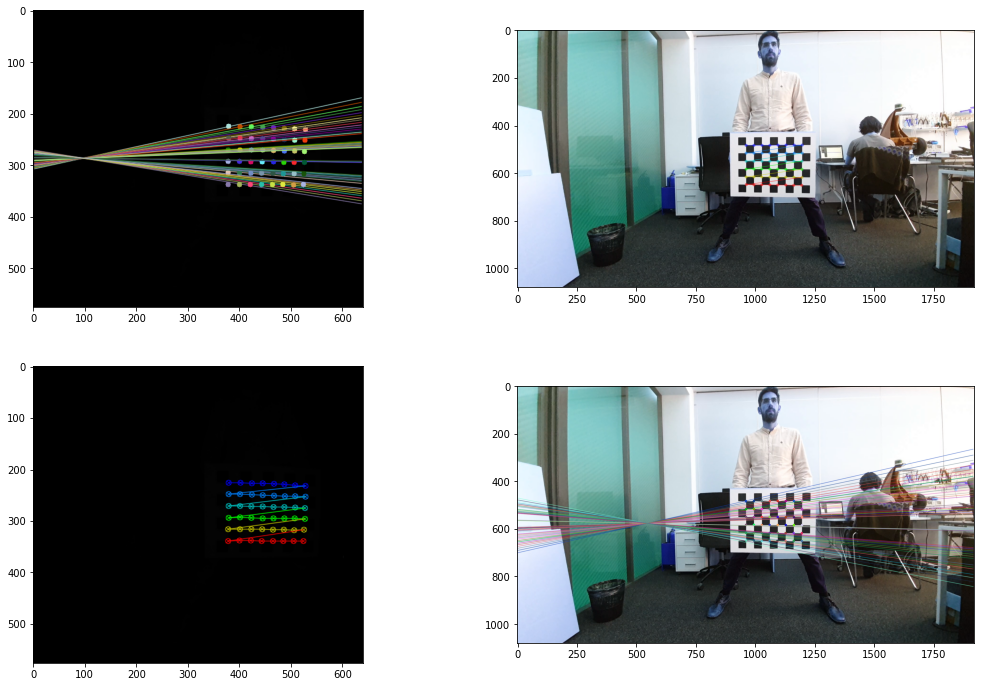

In [12]:
calib_name = "azure2s10"
output_stereo_calib_results(R12, T12, E12, F12, images1, images2, results1, results2, pattern_size, 0, pair_dict, calib_name)
